### SimpleITK-based pipeline for BRATS image segmentation


In [8893]:
import os
import numpy as np
import SimpleITK as sitk
# for interactive visualization
import matplotlib.pyplot as plt
%matplotlib inline
from slice_viewer import ImageSliceViewer3D
import random


DATADIR = "/home/shared/data/ITK-test/"
RESULTDIR = "Results/ITK_test"

sequences = ("flair","t1","t2","t1ce") #"label"

subject_id = "BraTS20_Training_116"  # replace with other subject_id
# these are the 20 Subjects from the training set:
#BraTS20_Training_010  BraTS20_Training_029  BraTS20_Training_075  BraTS20_Training_150  BraTS20_Training_180  BraTS20_Training_336  BraTS20_Training_365
#BraTS20_Training_021  BraTS20_Training_030  BraTS20_Training_108  BraTS20_Training_168  BraTS20_Training_233  BraTS20_Training_341  BraTS20_Training_366
#BraTS20_Training_027  BraTS20_Training_068  BraTS20_Training_124  BraTS20_Training_178  BraTS20_Training_253  BraTS20_Training_352

subject_ids =["BraTS20_Training_010", "BraTS20_Training_029", "BraTS20_Training_075", "BraTS20_Training_150", "BraTS20_Training_180", 
               "BraTS20_Training_336", "BraTS20_Training_365", "BraTS20_Training_021", "BraTS20_Training_030", "BraTS20_Training_108", 
               "BraTS20_Training_168", "BraTS20_Training_233", "BraTS20_Training_341", "BraTS20_Training_366", "BraTS20_Training_027", 
               "BraTS20_Training_068", "BraTS20_Training_124", "BraTS20_Training_178", "BraTS20_Training_253", "BraTS20_Training_352"]

In [8894]:
# LOAD all images of this subject (including ground truth for later evaluation)
images = {}
for seq in sequences:
    filename = os.path.join(DATADIR, subject_id, f"{subject_id}_{seq}.nii.gz")
    print(f"Load image from {filename} ")  #  load and convert to float for images and uint8 for label image
    images[seq] = sitk.ReadImage(filename, outputPixelType=sitk.sitkFloat32 if seq != "label" else sitk.sitkUInt8)

flair_image = images["flair"]
t1ce_image = images["t1ce"]
t1_image = images["t1"]
t2_image = images["t2"]
#label_image = images["label"]

Load image from /home/shared/data/ITK-test/BraTS20_Training_116/BraTS20_Training_116_flair.nii.gz 
Load image from /home/shared/data/ITK-test/BraTS20_Training_116/BraTS20_Training_116_t1.nii.gz 
Load image from /home/shared/data/ITK-test/BraTS20_Training_116/BraTS20_Training_116_t2.nii.gz 
Load image from /home/shared/data/ITK-test/BraTS20_Training_116/BraTS20_Training_116_t1ce.nii.gz 


### How to get help on specific SimpleITK functions or classes
`dir(sitk)` shows all attributes and functions of sitk.

`help()` displays the interface and a description for functions: For example: `help(sitk.RescaleIntensity)`



In [8895]:
help(sitk.RescaleIntensity)

Help on function RescaleIntensity in module SimpleITK.SimpleITK:

RescaleIntensity(image1, outputMinimum=0, outputMaximum=255)
    RescaleIntensity(Image image1, double outputMinimum=0, double outputMaximum=255) -> Image



In [8896]:
def evaluate_labels(prediction, ground_truth):
    """Compute measures for evaluation of segmentation masks.
    We assume the followin labels: 0 - background, 1-tumor, 2-edema.
    Parameters
    ----------
    prediction : sitk.Image
        predicted label image.
    ground_truth : sitk.Image | None
        ground_truth label image.
    Returns
    -------
    out_dirct: Dict
        a dictionary containing overlap measures for tumor, edema and tumor+edema, 
        see https://doi.org/10.54294/1vixgg for a description of the measures.
    """
    tumor_pred = sitk.BinaryThreshold(prediction, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
    tumor_gt = sitk.BinaryThreshold(ground_truth, lowerThreshold=1, upperThreshold=1, insideValue=1, outsideValue=0)
    edema_pred = sitk.BinaryThreshold(prediction, lowerThreshold=2, upperThreshold=2, insideValue=1, outsideValue=0)
    edema_gt = sitk.BinaryThreshold(ground_truth, lowerThreshold=2, upperThreshold=2, insideValue=1, outsideValue=0)
    edema_and_tumor_pred = sitk.BinaryThreshold(prediction, lowerThreshold=1, upperThreshold=2, insideValue=1, outsideValue=0)
    edema_and_tumor_gt = sitk.BinaryThreshold(ground_truth, lowerThreshold=1, upperThreshold=2, insideValue=1, outsideValue=0)
    measures1 = sitk.LabelOverlapMeasuresImageFilter()
    measures1.Execute(tumor_pred, tumor_gt)
    measures2 = sitk.LabelOverlapMeasuresImageFilter()
    measures2.Execute(edema_pred, edema_gt)
    measures3 = sitk.LabelOverlapMeasuresImageFilter()
    measures3.Execute(edema_and_tumor_pred, edema_and_tumor_gt)
    out_dict = {}
    for label, measure in [('Tumor(only)', measures1), ('Edema(only)', measures2), ('Edema and Tumor', measures3)]:
        out_dict[label] = {'Dice': measure.GetDiceCoefficient(), 'FalsePositiveError': measure.GetFalsePositiveError(), 
                           'FalseNegativeError': measure.GetFalseNegativeError(), 'Jaccard': measure.GetJaccardCoefficient()}
    return out_dict    

In [8897]:
# HISTOGRAMMDEHNUNG
def contrast_stretching(sitk_image):
    """
    Perform contrast stretching on a 3D SimpleITK image.
    Returns an 8-bit UInt8 image with the same spatial metadata.

    Arguments: 
    image: sitk_image

    Returns: 
    stretched_image: output of the constrast stretching
    """
    
    arr = sitk.GetArrayViewFromImage(sitk_image)
    imin, imax = arr.min(), arr.max()
    # Stretch to [0,255]
    stretched_image = (sitk_image - imin) * (255.0 / (imax - imin))
    stretched_image = sitk.Cast(stretched_image, sitk.sitkUInt8)
    # Preserve origin, spacing, direction
    stretched_image.CopyInformation(sitk_image)
    return stretched_image

In [8898]:
# SCHWELLWERTSEGMENTIERUNG 
def thresholding(input_image):
    """
    Führt eine binäre Schwellwertsegmentierung auf dem Eingabebild durch.

    Arguments:
    image: input_image (SimpleITK.Image)

    Return:
    thresholded_image: Das binäre Segmentierungsbild mit Werten 0 und 1.
    """
    threshold_filter = sitk.BinaryThresholdImageFilter()
    threshold_filter.SetLowerThreshold(100)
    threshold_filter.SetUpperThreshold(255)
    threshold_filter.SetInsideValue(1)
    threshold_filter.SetOutsideValue(0)
    thresholded_image = threshold_filter.Execute(input_image)

    #Ergebnis ist binär (0, 1), skaliere auf 0 und 255 für besseres 8-Bit-Format
    
    thresholded_image.CopyInformation(input_image)
    
    return thresholded_image

In [8899]:
def erosion(input_image):
    """
    Führt eine Grauwert-Erosion auf dem Eingabebild durch.

    Arguments:
    image: input_image (SimpleITK.Image)

    Returns:
    eroded_image: Ausgabe des Bildes nach der Erosion, 8-bit UInt8 image 
    """
    # erosion
    eroded_image = sitk.GrayscaleErode(input_image)
    
    eroded_img = sitk.Cast(eroded_image, sitk.sitkUInt8) # in 8-bit (UInt8) konvertieren
    eroded_img.CopyInformation(input_image) #copy metadata

    return eroded_img

In [8900]:
def dilate(image: sitk.Image, radius=1) -> sitk.Image:
    """
    Führt eine Grauwert-Dilatation auf dem Eingabebild durch.

    Args:
        image (sitk.Image): Grauwertbild (z. B. MRT-Bild).
        radius (int oder Tuple[int]): Radius des strukturellen Elements.

    Returns:
        sitk.Image: Ausgabe des Bildes nach der Dilatation, 8-bit UInt8 image 
    """

    dilation = sitk.GrayscaleDilate(image, kernelRadius=radius)
    dilation_img = sitk.Cast(dilation, sitk.sitkUInt8) # in 8-bit (UInt8) konvertieren
    dilation_img.CopyInformation(image) #copy metadata
    return dilation_img


In [8901]:
def get_seeds(sitk_image, mask=None, num_seeds=5):
    
    """
    Extrahiert Seed-Punkte aus einem Bild für Region-Growing
    
    Parameter:
    sitk_image (SimpleITK.Image): Das Eingabebild, aus dem Seed-Punkte extrahiert werden.
    mask (None): Eine optionale Maske, um die Auswahl der Seed-Punkte auf eine bestimmte Region zu beschränken.
    num_seeds (int): Anzahl der zu extrahierenden Seed-Punkte (Standard: 5).

    Rückgabe:
    seeds: Liste der Seed-Punkte als Voxel-Koordinaten im Format (x, y, z).
    """
    #Benutzt vorverarbeitetes Bild
    preprocessed_image = preprocess_for_edema_segmentation(sitk_image)


    #Wandle Bild in NumPy-Array um und wende Erosion an 
    arr = sitk.GetArrayFromImage(erosion(sitk_image))

    if mask is not None:
        # Wenn Maske vorhanden ist: nur Koordinaten innerhalb der Maske verwenden
        mask_arr = sitk.GetArrayFromImage(mask) > 0
        coords = np.argwhere(mask_arr)
    else:
        # Ohne Maske: wähle die obersten 1 % der Pixelintensitäten als Kandidaten für Seed-Punkte
        thresh = np.percentile(arr, 99)  # top 1%
        coords = np.argwhere(arr > thresh)
        
    # Optional: Filtere Koordinaten nach bestimmter Z-Scheibe                     
    coords = [c for c in coords if 79 <= c[0] <= 81]

    # Sortiere die Kandidaten absteigend nach Intensität
    coords_sorted = sorted(coords, key=lambda c: arr[tuple(c)], reverse=True)

    # konvertiere die Koordinaten von (z, y, x) nach (x, y, z) und gib die Top-N zurück
    seeds = [(int(c[2]), int(c[1]), int(c[0])) for c in coords_sorted[:num_seeds]]

    return seeds

In [8902]:
def preprocess_for_edema_segmentation(img):
    """ .
    Führt eine Vorverarbeitung auf einem FLAIR-MRT-Bild zur Ödemsegmentierung durch.

    Vorverarbeitungspipeline:
        1. Histogrammdehnung zur Kontrastverbesserung
        2. Glättung mit einem Gauß-Filter
        3. Binäre Schwellwertsegmentierung
        4. Morphologische Erosion zur Rauschreduktion

    Parameter:
    ----------
    img : SimpleITK.Image
        Eingabebild (z. B. FLAIR-Sequenz eines MRT-Scans)

    Rückgabe:
    -------
    SimpleITK.Image
        Das vorverarbeitete Bild als binäres Segmentierungsresultat (0 und 1)
     """
    
# 1.1 Vorverarbeitung: HISTOGRAMMDEHNUNG
    flair_histodehnung = contrast_stretching(img)

#1.2 Vorverarbeitung: GAUßFILTER
    gaussian_filter = sitk.DiscreteGaussianImageFilter()
    gaussian_filter.SetVariance(2.0)
    smoothed_image = gaussian_filter.Execute(flair_histodehnung)
    
# 1.3 Vorverarbeitung: SCHWELLWERTSEGMENTIERUNG mit Binary Thresholding
    thresholded_image = thresholding(smoothed_image) # -> Glättung ist wichtig!
    

# 1.4 Vorverarbeitung: EROSION
    erosion_image = erosion(thresholded_image)
    processed_img = erosion_image
    
    return processed_img

In [8903]:
'''
# Originalbild laden – Sequenz 'flair'
flair_image = images["flair"]
label_mask = images.get("label", None)

# Extrahiere Seed-Punkte aus dem Bild (ggf. unter Berücksichtigung der Maske)
seeds = get_seeds(flair_image, mask=None, num_seeds = 5) # num_seeds = 5
#print("Extracted seeds:", seeds)

# Nimm den ersten Seed für die Region-Growing-Segmentierung
seed = seeds[0]
#print("Extracted seed:", seed)
'''

'\n# Originalbild laden – Sequenz \'flair\'\nflair_image = images["flair"]\nlabel_mask = images.get("label", None)\n\n# Extrahiere Seed-Punkte aus dem Bild (ggf. unter Berücksichtigung der Maske)\nseeds = get_seeds(flair_image, mask=None, num_seeds = 5) # num_seeds = 5\n#print("Extracted seeds:", seeds)\n\n# Nimm den ersten Seed für die Region-Growing-Segmentierung\nseed = seeds[0]\n#print("Extracted seed:", seed)\n'

In [8904]:
def find_threshold(input_image, seed):
    """
    Bestimmt untere und obere Schwellwerte für die Region-Growing-Segmentierung basierend auf dem Seed-Punkt.

    Arguments:
    ----------
    input_image (SimpleITK.Image): Das Eingabebild, aus dem die Intensitäten gelesen werden.
    seed: Seed-Koordinaten im Format (x, y, z).

    Return:
    -------
    lower_threshold, upper_threshold): - lower_threshold: Untere Intensitätsgrenze (Seedwert - 150), upper_threshold: Maximale Intensität im Bild
    """
    
    # Wandle Bild in NumPy-Array (Achtung: Reihenfolge [z, y, x])
    input_array = sitk.GetArrayViewFromImage(input_image)  # Achtung: [z,y,x] Reihenfolge!
    seed_z, seed_y, seed_x = seed[2], seed[1], seed[0]
    
    # Intensitätswert des Seed-Punkts
    seed_value = input_array[(seed_z, seed_y, seed_x)]
    
    # Schwellwert muss manuell angepasst werden
    lower_threshold = seed_value - 100 
    upper_threshold = np.max(input_array)

    return lower_threshold, upper_threshold

(90.0, 993.0)


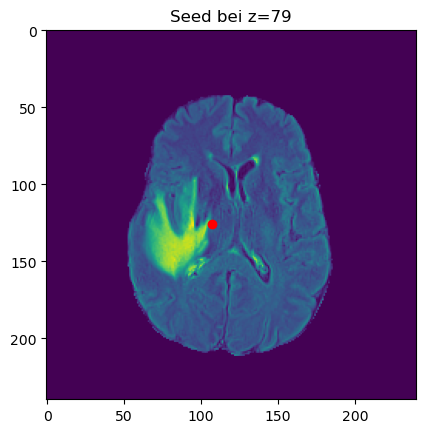

Zeige Bild nach Region Growing BraTS20_Training_116


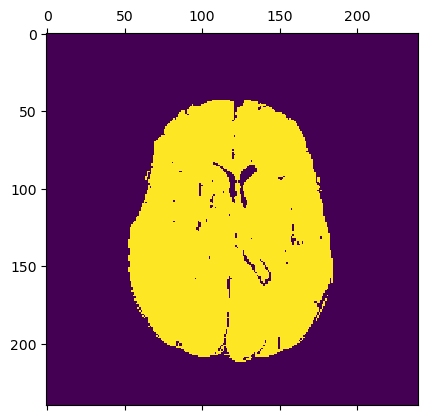

In [8905]:

##ZUM ANZEIGEN BEI BEDARF
# 1. Bildvorverarbeitung
input_img = preprocess_for_edema_segmentation(flair_image)

# 2. Schwellwerte basierend auf dem Seed bestimmen
get_threshold = find_threshold(flair_image, seed)
print(get_threshold)

# 3. Region Growing ausführen
edema_segmentation1 = region_growing(flair_image, seed, lower_threshold = get_threshold[0], upper_threshold = get_threshold[1])


# seed im Flair Bild anzeigen
slice_index = seed[2]  # z-Ebene des Seeds

plt.imshow(sitk.GetArrayFromImage(flair_image)[slice_index])
plt.plot(seed[0], seed[1], "ro")  # seed als roten Punkt darstellen
plt.title(f"Seed bei z={slice_index}")
plt.show()

print("Zeige Bild nach Region Growing " + subject_id)
edema = sitk.GetArrayFromImage(edema_segmentation1)
plt.matshow(edema[80])

In [8906]:
from collections import deque

def region_growing(input_image, seed, lower_threshold, upper_threshold):
    """
    Führt ein effizientes 3D-Region-Growing-Verfahren ausgehend von einem Seed-Punkt durch.

    Die Region wird iterativ über eine 6er-Nachbarschaft erweitert, 
    solange benachbarte Voxel innerhalb der gegebenen Intensitätsschwellen liegen.

    Parameter:
    ----------
    input_image (SimpleITK.Image): Das Eingabebild (z. B. MRT-Volumen)
    seed (tuple): Startpunkt im Format (x, y, z)
    lower_threshold (float): Untere Intensitätsgrenze für Region Inclusion
    upper_threshold (float): Obere Intensitätsgrenze für Region Inclusion

    Rückgabe:
    --------
    SimpleITK.Image: Binäre Maske (0/1) des segmentierten Bereichs als 3D-Bild
    """

    # Hole Array einmalig
    #input_array = sitk.GetArrayViewFromImage(input_image)  # Achtung: [z,y,x] Reihenfolge!
    input_array = sitk.GetArrayFromImage(input_image)
    
    # Erstelle eine leere Maske für die Region (wie input_array, aber 0/1)
    region_array = np.zeros_like(input_array, dtype=np.uint8)

    # Achtung: Seed umdrehen von (x,y,z) zu (z,y,x) wegen Array-Indexierung!
    seed_z, seed_y, seed_x = seed[2], seed[1], seed[0]
    
    # Check if the seed point is valid
    if not (0 <= seed[0] < input_array.shape[0] and 0 <= seed[1] < input_array.shape[1] and 0 <= seed[2] < input_array.shape[2]):
        raise ValueError(f"Seed point {seed} is outside of the image dimensions.", input_array.shape)
    
    # Erstelle ein Besuchtes-Array (gleiche Größe)
    visited = np.zeros_like(input_array, dtype=bool)

    # Check the intensity of the seed point
    seed_value = input_array[(seed_z, seed_y, seed_x)]
    #print(f"Seed intensity at {(seed_z, seed_y, seed_x)}: {seed_value}")

    # Initialisiere Queue
    queue = deque()
    queue.append((seed_z, seed_y, seed_x))
    visited[seed_z, seed_y, seed_x] = True # Punkte, die besucht wurden
    region_array[seed_z, seed_y, seed_x] = 1 # der punkt, der gerade untersucht wird

    # Starte Region Growing
    while queue:
        cz, cy, cx = queue.popleft()

        # 6er Nachbarschaft
        neighbors = [
            (cz+1, cy, cx),
            (cz-1, cy, cx),
            (cz, cy+1, cx),
            (cz, cy-1, cx),
            (cz, cy, cx+1),
            (cz, cy, cx-1),
        ]

        for nz, ny, nx in neighbors:
            if 0 <= nz < input_array.shape[0] and 0 <= ny < input_array.shape[1] and 0 <= nx < input_array.shape[2]:
                if not visited[nz, ny, nx]:

                    if lower_threshold <= input_array[nz, ny, nx] <= upper_threshold: # überprüfen, ob Punkt innerhalb der Schwellwerte liegt
                        region_array[nz, ny, nx] = 1 
                        queue.append((nz, ny, nx)) 

                    visited[nz, ny, nx] = True  # Als besucht markieren

    # Baue das Ergebnis als SimpleITK-Bild zurück
    region_grown_image = sitk.GetImageFromArray(region_array)
    region_grown_image.CopyInformation(input_image)

    #return seed_value
    return region_grown_image

In [8907]:
def postprocess_for_edema_closing(input_image):
    """
    Führt ein morphologisches Closing zur Nachbearbeitung der binären Ödem-Segmentierung durch.

    Das Closing besteht aus:
        1. Binärer Dilatation
        2. Binärer Erosion

    Diese Operation schließt kleine Löcher im Segment und glättet die Ränder.

    Parameter:
    ----------
    image (SimpleITK.Image): Binäres Segmentierungsbild (0/1)

    Rückgabe:
    --------
    SimpleITK.Image: Nachbearbeitetes Segmentierungsbild nach Closing (UInt8, 0/1)
    """
## BINÄRE EROSION
    def binary_erosion(input_image): #, radius=(1, 1, 1), foreground_value=1
        # binary erosion
        eroded_image = sitk.BinaryErode(input_image) # kernelRadius=radius, foregroundValue=foreground_value
    
        eroded_img = sitk.Cast(eroded_image, sitk.sitkUInt8)
        eroded_img.CopyInformation(input_image)

        return eroded_img

## BINÄRE DILATATION
    def binary_dilation(input_image): #, radius=(1, 1, 1), foreground_value=1
        # binary dilation
        dilated_image = sitk.BinaryDilate(input_image) # kernelRadius=radius, foregroundValue=foreground_value
    
        # Cast to UInt8 and preserve spatial metadata
        dilated_img = sitk.Cast(dilated_image, sitk.sitkUInt8)
        dilated_img.CopyInformation(input_image)
    
        return dilated_img

    # OPENING
    eroded = binary_erosion(input_image)
    opened = binary_dilation(eroded)

    # CLOSING
    dilated = binary_dilation(input_image)
    closed = binary_erosion(dilated)
    
    return closed

In [8908]:
def postprocess_for_edema_opening(image):
    """
    Führt ein morphologisches Opening zur Nachbearbeitung der binären Ödem-Segmentierung durch.

    Das Closing besteht aus:
        1. Binärer Erosion
        2. Binärer Dilatation

    Parameter:
    ----------
    image (SimpleITK.Image): Binäres Segmentierungsbild (0/1)

    Rückgabe:
    --------
    SimpleITK.Image: Nachbearbeitetes Segmentierungsbild nach Closing (UInt8, 0/1)
    """
## BINÄRE EROSION
    def binary_erosion(input_image): #, radius=(1, 1, 1), foreground_value=1
        # binary erosion
        eroded_image = sitk.BinaryErode(input_image) # kernelRadius=radius, foregroundValue=foreground_value
    
        eroded_img = sitk.Cast(eroded_image, sitk.sitkUInt8)
        eroded_img.CopyInformation(input_image)

        return eroded_img

## BINÄRE DILATATION
    def binary_dilation(input_image): #, radius=(1, 1, 1), foreground_value=1
        # binary dilation
        dilated_image = sitk.BinaryDilate(input_image) # kernelRadius=radius, foregroundValue=foreground_value
    
        # Cast to UInt8 and preserve spatial metadata
        dilated_img = sitk.Cast(dilated_image, sitk.sitkUInt8)
        dilated_img.CopyInformation(input_image)
    
        return dilated_img

    # OPENING
    eroded = binary_erosion(image)
    opened = binary_dilation(eroded)

    # CLOSING
    dilated = binary_dilation(image)
    closed = binary_erosion(dilated)
    
    return opened 

In [8909]:
# 1. Morphologisches Closing: Schließt kleine Löcher innerhalb der Segmentmaske
#postprocessed_image = postprocess_for_edema_closing(edema_segmentation)

# 2. Opening (zweimal): Entfernt kleine isolierte Punkte und glättet Ränder
#postprocessed_image2 = postprocess_for_edema_opening(postprocessed_image)
#postprocessed_image3 = postprocess_for_edema_opening(postprocessed_image2)

# 3. Umwandlung in NumPy-Array zur Visualisierung 
#postprocessed = sitk.GetArrayFromImage(postprocessed_image2) #postprocessed_image
#plt.matshow(postprocessed[80]) # 80 gibt slice an 

In [8910]:
def dice_one(label_image, predicted_image):
    """
    Berechnet den Dice-Koeffizienten zwischen Ground-Truth und vorhergesagter Segmentierung.

    Arguments:
    ----------
    label_image (SimpleITK.Image): Ground-Truth-Segmentierung
    predicted_image (SimpleITK.Image): Vorhergesagte Segmentierung
    subject_name (str): Optionaler Name des Subjekts zur Anzeige

    Return:
    -------
    float: Dice-Koeffizient für Klasse 1 (binäre Maske)
    """

    fn = sitk.LabelOverlapMeasuresImageFilter()
    fn.Execute(predicted_image, label_image)
    sitk_dice1 = fn.GetDiceCoefficient(1) # Get Dice class 1
    sitk_dice2 = fn.GetDiceCoefficient(2) # Get Dice class 1
    sitk_dice = (sitk_dice1 + sitk_dice2) / 2 
    print("Dice von " + subject + ": " , sitk_dice)

In [8911]:
def dice_all(label_image, predicted_image):
    """
    Berechnet den Dice-Koeffizienten zwischen Ground-Truth und vorhergesagter Segmentierung.

    Arguments:
    ----------
    label_image (SimpleITK.Image): Ground-Truth-Segmentierung
    predicted_image (SimpleITK.Image): Vorhergesagte Segmentierung
    subject_name (str): Optionaler Name des Subjekts zur Anzeige

    Return:
    -------
    float: Dice-Koeffizient für Klasse 1 (binäre Maske)
    """

    fn = sitk.LabelOverlapMeasuresImageFilter()
    fn.Execute(predicted_image, label_image)
    sitk_dice1 = fn.GetDiceCoefficient(1) # Get Dice class 1
    sitk_dice2 = fn.GetDiceCoefficient(2) # Get Dice class 1
    sitk_dice = (sitk_dice1 + sitk_dice2) / 2 
    print("Dice von " + subject + ": " , sitk_dice)

In [8912]:
# gesamte PIPELINE jetzt hier implementieren

def segment_edema(img):
    """
    Führt die komplette Segmentierungspipeline zur Ödementdeckung durch.

    Schritte:
    - Vorverarbeitung (Kontrast, Glättung, Thresholding, Erosion)
    - Seed-Extraktion
    - Region Growing
    - Morphologische Nachbearbeitung (Closing + Opening)
    - (Optional) Dice-Berechnung, wenn Label vorhanden

    Arguments:
    ----------
    img (SimpleITK.Image): Das FLAIR-MRT-Bild des Patienten

    Return:
    --------
    SimpleITK.Image: Final segmentiertes Ödem nach Nachbearbeitung
    """
    ## VORVERARBEITUNG
    preprocessed_img = preprocess_for_edema_segmentation(img)

    ## SEEDS 
    seeds = get_seeds(img, mask=None, num_seeds = 5)
    seed = seeds[0] # region growing übernimmt nur ein Saatpunkt
    
    # um LOWER_ & UPPER_THRESHOLD zu definieren
    get_threshold = find_threshold(img, seed)

    edema_segmentation = region_growing(img, seed, lower_threshold = get_threshold[0], upper_threshold = get_threshold[1])
    

    ## Bild zeigen nach edema_segmentation
    #edema = sitk.GetArrayFromImage(edema_segmentation)
    #plt.matshow(edema[80])

    ## NACHVERARBEITUNG
    postprocessed_image = postprocess_for_edema_closing(edema_segmentation)
    postprocessed_image2 = postprocess_for_edema_opening(postprocessed_image)
    
    postprocessed = sitk.GetArrayFromImage(postprocessed_image2) #postprocessed_image
    

    ## AUSWERTUNG
    #label_image = images["label"]
    #label = sitk.GetArrayFromImage(label_image)
    
    #dice_one(label_image, postprocessed_image2) ## mit DICE 
    #dice_all(label_image, postprocessed_image2) # wenn für alle Daten Dice ausgegeben werden soll

    # Anzeigen
    #plt.matshow(postprocessed[80])
    #plt.title("Zeige Bild nach Ödemsegmentierung " + subject_id)

    #plt.matshow(label[80])
    #plt.title("Zeige Label von: " + subject_id)
    
    return postprocessed_image2

In [8913]:
#plt.hist(img.flatten()) # um Histogramm eines Bildes auszugeben - zeigt Grauwertverteilung an

In [8914]:
#flair_arr = sitk.GetArrayFromImage(flair_image)
#plt.show(flair_arr[80])

### ÖDEM

In [8915]:
# alle Ödem_Dice Werte - bei Bedarf auskommentieren
# ACHTUNG - in segment_edema Funktion muss dice_all auskommentiert werden und dice_one kommentiert werden!
'''
for subject in subject_ids:
    #print(f"Verarbeite Subjekt: {subject}")
    flair_filename = os.path.join(DATADIR, subject, f"{subject}_flair.nii.gz")
    if not os.path.exists(flair_filename):
        print(f"FLAIR nicht gefunden für {subject}, überspringe.")
        continue

    flair_final = sitk.ReadImage(flair_filename, outputPixelType=sitk.sitkFloat32)

    #print(f"Bild geladen: {flair_filename}")
    
    try:
        segment_edema(flair_final)
    except ValueError as e:
        print(f"Fehler bei Segmentierung von {subject}")
        continue
'''

'\nfor subject in subject_ids:\n    #print(f"Verarbeite Subjekt: {subject}")\n    flair_filename = os.path.join(DATADIR, subject, f"{subject}_flair.nii.gz")\n    if not os.path.exists(flair_filename):\n        print(f"FLAIR nicht gefunden für {subject}, überspringe.")\n        continue\n\n    flair_final = sitk.ReadImage(flair_filename, outputPixelType=sitk.sitkFloat32)\n\n    #print(f"Bild geladen: {flair_filename}")\n    \n    try:\n        segment_edema(flair_final)\n    except ValueError as e:\n        print(f"Fehler bei Segmentierung von {subject}")\n        continue\n'

### TUMOR

In [8916]:
# um T1CE Bild anzuzeigen
#t1ce_image = images["t1ce"]

t1ce_img = sitk.GetArrayFromImage(t1ce_image) #postprocessed_image
#plt.matshow(t1ce_img[80])

t1_img = sitk.GetArrayFromImage(t1_image)
#plt.matshow(t1_img[80])

In [8917]:
# SCHWELLWERTSEGMENTIERUNG 
def thresholding_t1ce(img):
    """
    Führt eine binäre Schwellwertsegmentierung zur Tumorerkennung durch.

    Voxel mit Intensitäten innerhalb des Bereichs [lower, upper] werden als Tumor klassifiziert (Wert = 1),
    alle anderen als Hintergrund (Wert = 0).

    Arguments:
    ----------
    img (SimpleITK.Image): Eingabebild (z. B. T1ce-Bild)
    lower (int): Untere Schwelle (Standard: 110)
    upper (int): Obere Schwelle (Standard: 200)

    Return:
    --------
    SimpleITK.Image: Binäres Bild (0/1), das das segmentierte Tumorgewebe darstellt
    """
    threshold_filter = sitk.BinaryThresholdImageFilter()
    threshold_filter.SetLowerThreshold(100)
    threshold_filter.SetUpperThreshold(220)
    threshold_filter.SetInsideValue(1)
    threshold_filter.SetOutsideValue(0)
    thresholded_image = threshold_filter.Execute(img)

    #Ergebnis ist binär (0, 1), skaliere auf 0 und 255 für besseres 8-Bit-Format
    #thresholded_img = sitk.Cast(thresholded_image * 255, sitk.sitkUInt8)
    thresholded_image.CopyInformation(img)
    
    return thresholded_image

In [8918]:
# SCHWELLWERTSEGMENTIERUNG 
def thresholding_t1(img):
    """
    Führt eine binäre Schwellwertsegmentierung zur Tumorerkennung durch.

    Voxel mit Intensitäten innerhalb des Bereichs [lower, upper] werden als Tumor klassifiziert (Wert = 1),
    alle anderen als Hintergrund (Wert = 0).

    Arguments:
    ----------
    img (SimpleITK.Image): Eingabebild (z. B. T1-Bild)

    Return:
    --------
    SimpleITK.Image: Binäres Bild (0/1), das das segmentierte Tumorgewebe darstellt
    """
    threshold_filter = sitk.BinaryThresholdImageFilter()
    threshold_filter.SetLowerThreshold(20)
    threshold_filter.SetUpperThreshold(130)
    threshold_filter.SetInsideValue(1)
    threshold_filter.SetOutsideValue(0)
    thresholded_image = threshold_filter.Execute(img)

    #Ergebnis ist binär (0, 1), skaliere auf 0 und 255 für besseres 8-Bit-Format
    #thresholded_img = sitk.Cast(thresholded_image * 255, sitk.sitkUInt8)
    thresholded_image.CopyInformation(img)
    
    return thresholded_image

In [8919]:
def segment_tumor(t1ce_img, t1_img, flair_img):
    """
    Führt eine Verarbeitung zur Tumorsegmentierung durch.

    Schritte:
    Vorverarbeitung
    1. Histogrammdehnung zur Kontrastverbesserung
    2. Segmentierung des Ödems
    3. Segmentierung des Tumors
    4. Kombination der T1 und T1ce Masken
    Nachverarbeitung
    5. Morphologisches Closing zur Löcherfüllung
    6. Markierung des Ödems ohne Tumor

    Arguments:
    ----------
    t1ce_img : SimpleITK.Image - Eingabebild (T1ce-MRT)
    t1_img : SimpleITK.Image - Eingabebild (T1-MRT)
    flair_img : SimpleITK.Image - Eingabebild (Flair-MRT)

    Return:
    --------
    edema_mask_ohne_tumor:Verarbeitete Ödemmaske mit abgezogenen Tumor als binäres Bild (0/1) 
    closing2_tumor_mask: Segmentierte Tumormaske als binäres Bild (0/1)
    """
    # Schritt 1: Histogrammdehnung
    stretched_t1ce = contrast_stretching(t1ce_img)
    stretched_t1 = contrast_stretching(t1_img)
    
    # Schritt 2: Schwellwertsegmentierung für Ödem
    edema_mask = segment_edema(flair_img)
    
    # Schritt 3: Schwellwertsegmentierung für Tumor
    tumor_mask_t1ce = thresholding_t1ce(stretched_t1ce)
    tumor_mask_t1 = thresholding_t1(stretched_t1)

    # Schritt4: t1 und t1ce Masken kombinieren
    tumor_combined_mask = sitk.And(tumor_mask_t1ce, tumor_mask_t1)
    tumor_mask = sitk.And(edema_mask, tumor_combined_mask)
    
    # Schritt 5: Löcher füllen per Closing und Dilation
    closing_tumor_mask = sitk.BinaryMorphologicalClosing(tumor_mask, kernelRadius=[2, 2, 1]) # etwas größerer Radius
    dilated_tumor_mask = sitk.BinaryDilate(closing_tumor_mask, kernelRadius= [1, 1, 1])
    closing2_tumor_mask = sitk.BinaryMorphologicalClosing(dilated_tumor_mask, kernelRadius=[2, 2, 1]) # etwas größerer Radius

    segmented_tumor = closing2_tumor_mask
    # Schritt 6: Markierung des Ödems ohne Tumor für späteres Label
    #edema_mask_ohne_tumor = sitk.And(edema_mask, sitk.Not(closing2_tumor_mask))

    # zum Anzeigen:
    tumor_arr = sitk.GetArrayFromImage(closing2_tumor_mask)
    #plt.matshow(tumor_arr[80])
    #plt.title("Zeige Bild nach Tumorverarbeitung " + subject_id)
        
    return segmented_tumor

In [8920]:
#segment_tumor(t1ce_image, t1_image, flair_image)
#edema1 = segment_edema(flair_image)
#edema_array = sitk.GetArrayFromImage(edema1)
#plt.matshow(edema_array[80])

In [8921]:
def erstellt_label(t1ce_img, t1_img, flair_img):
    
    final_edema = segment_edema(flair_img)
    final_tumor = segment_tumor(t1ce_img, t1_img, flair_img)

    # Schritt 6: Markierung des Ödems ohne Tumor für späteres Label
    edema_mask_ohne_tumor = sitk.And(final_edema, sitk.Not(final_tumor))
    
    tumor = sitk.And(final_edema, final_tumor)
    edema_ot= sitk.And(final_edema, sitk.Not(tumor))

    label1 = tumor * 1
    label2 = edema_ot * 2
                              
    final_segmentation = label1 + label2

    #edema_arr = sitk.GetArrayFromImage(final_edema)
    #plt.matshow(edema_arr[80])
    
    final_segmentation_as_npy = sitk.GetArrayFromImage(final_segmentation)
    #plt.matshow(test[80])
    #plt.title("Zeige Label mit Tumor- & Ödem-Segmentierung " + subject_id)

    return final_segmentation

In [8922]:
#erstellt_label(t1ce_image, t1_image, flair_image)

In [8923]:
# alle Tumor_Dice Werte - bei Bedarf auskommentieren 
# ACHTUNG - in segment_tumor Funktion muss dice_all auskommentiert werden und dice_one kommentiert werden!
'''
for subject in subject_ids:
    #print(f"Verarbeite Subjekt: {subject}")
    t1ce_filename = os.path.join(DATADIR, subject, f"{subject}_t1ce.nii.gz")
    if not os.path.exists(t1ce_filename):
        print(f"T1ce nicht gefunden für {subject}, überspringe.")
        continue

    tumor_final = sitk.ReadImage(t1ce_filename, outputPixelType=sitk.sitkFloat32)

    #label_image = images["label"]
    #label = sitk.GetArrayFromImage(label_image)
    #plt.matshow(label[80])
    #plt.title("Zeige Label von: " + subject)

    #print(f"Bild geladen: {flair_filename}")

    try:
        segment_tumor(tumor_final)
    except ValueError as e:
        print(f"Fehler bei Segmentierung von {subject}: {e}")
        continue
'''

'\nfor subject in subject_ids:\n    #print(f"Verarbeite Subjekt: {subject}")\n    t1ce_filename = os.path.join(DATADIR, subject, f"{subject}_t1ce.nii.gz")\n    if not os.path.exists(t1ce_filename):\n        print(f"T1ce nicht gefunden für {subject}, überspringe.")\n        continue\n\n    tumor_final = sitk.ReadImage(t1ce_filename, outputPixelType=sitk.sitkFloat32)\n\n    #label_image = images["label"]\n    #label = sitk.GetArrayFromImage(label_image)\n    #plt.matshow(label[80])\n    #plt.title("Zeige Label von: " + subject)\n\n    #print(f"Bild geladen: {flair_filename}")\n\n    try:\n        segment_tumor(tumor_final)\n    except ValueError as e:\n        print(f"Fehler bei Segmentierung von {subject}: {e}")\n        continue\n'

In [8924]:
'''
def evaluation(edema, tumor, label_image):
    """
    Arguments:
    ----------
    edema (SimpleITK.Image): FLAIR-Bild für Ödemsegmentierung
    tumor (SimpleITK.Image): T1ce-Bild für Tumorsegmentierung
    label_image (SimpleITK.Image): Ground-Truth-Maske
    
    """
    
    edema_segmentation = segment_edema(edema)
    tumor_segmentation = segment_tumor(tumor)

    overlap = sitk.And(edema_segmentation, tumor_segmentation)

    measures = sitk.LabelOverlapMeasuresImageFilter()
    label_bin = sitk.BinaryThreshold(label_image, lowerThreshold=1)
    measures.Execute(overlap, label_bin)

    print("Dice:", measures.GetDiceCoefficient(1))
    print("FNR:", measures.GetFalseNegativeError(1))
    print("FPR:", measures.GetFalsePositiveError(1))

    eval_dict = evaluate_labels(overlap * 2, label_image)
    print(eval_dict)
'''

'\ndef evaluation(edema, tumor, label_image):\n    """\n    Arguments:\n    ----------\n    edema (SimpleITK.Image): FLAIR-Bild für Ödemsegmentierung\n    tumor (SimpleITK.Image): T1ce-Bild für Tumorsegmentierung\n    label_image (SimpleITK.Image): Ground-Truth-Maske\n    \n    """\n    \n    edema_segmentation = segment_edema(edema)\n    tumor_segmentation = segment_tumor(tumor)\n\n    overlap = sitk.And(edema_segmentation, tumor_segmentation)\n\n    measures = sitk.LabelOverlapMeasuresImageFilter()\n    label_bin = sitk.BinaryThreshold(label_image, lowerThreshold=1)\n    measures.Execute(overlap, label_bin)\n\n    print("Dice:", measures.GetDiceCoefficient(1))\n    print("FNR:", measures.GetFalseNegativeError(1))\n    print("FPR:", measures.GetFalsePositiveError(1))\n\n    eval_dict = evaluate_labels(overlap * 2, label_image)\n    print(eval_dict)\n'

In [8925]:
## ein einzelnes Bild evaluieren -> oben einstellen welches Bild evaluiert werden soll 
#evaluation(flair_image, t1ce_image, label_image)

In [8926]:
## um alle Bilder zu evaluieren - bei Bedarf auskommentieren 
# ACHTUNG - in segment_tumor und segment_edema Funktion muss dice_all auskommentiert werden und dice_one kommentiert werden!
'''
for subject in subject_ids:
    flair_filename = os.path.join(DATADIR, subject, f"{subject}_flair.nii.gz")
    t1ce_filename = os.path.join(DATADIR, subject, f"{subject}_t1ce.nii.gz")
    label_filename = os.path.join(DATADIR, subject, f"{subject}_label.nii.gz")

    if not all(os.path.exists(p) for p in [flair_filename, t1ce_filename, label_filename]):
        print(f"Ein oder mehrere Dateien fehlen für {subject}, überspringe.")
        continue

    try:
        flair_img = sitk.ReadImage(flair_filename, outputPixelType=sitk.sitkFloat32)
        t1ce_img = sitk.ReadImage(t1ce_filename, outputPixelType=sitk.sitkFloat32)
        label_img = sitk.ReadImage(label_filename, outputPixelType=sitk.sitkUInt8)

        print(f"Evaluierung für {subject}...")
        evaluation(flair_img, t1ce_img, label_img)
        
    except Exception as e:
        print(f"Fehler bei {subject}: {e}")
        continue
'''

'\nfor subject in subject_ids:\n    flair_filename = os.path.join(DATADIR, subject, f"{subject}_flair.nii.gz")\n    t1ce_filename = os.path.join(DATADIR, subject, f"{subject}_t1ce.nii.gz")\n    label_filename = os.path.join(DATADIR, subject, f"{subject}_label.nii.gz")\n\n    if not all(os.path.exists(p) for p in [flair_filename, t1ce_filename, label_filename]):\n        print(f"Ein oder mehrere Dateien fehlen für {subject}, überspringe.")\n        continue\n\n    try:\n        flair_img = sitk.ReadImage(flair_filename, outputPixelType=sitk.sitkFloat32)\n        t1ce_img = sitk.ReadImage(t1ce_filename, outputPixelType=sitk.sitkFloat32)\n        label_img = sitk.ReadImage(label_filename, outputPixelType=sitk.sitkUInt8)\n\n        print(f"Evaluierung für {subject}...")\n        evaluation(flair_img, t1ce_img, label_img)\n        \n    except Exception as e:\n        print(f"Fehler bei {subject}: {e}")\n        continue\n'

In [8927]:
'''
final_edema = segment_edema(flair_image)
final_tumor = segment_tumor(t1ce_image)

tumor = sitk.And(final_edema, final_tumor)
edema_ot= sitk.And(final_edema, sitk.Not(tumor))

label1 = tumor * 1
label2 = edema_ot * 2
                              
final_segmentation = label1 + label2

test = sitk.GetArrayFromImage(final_segmentation)
plt.matshow(test[80])

#save_prediction(test, 'BraTS20_Training_116', RESULTDIR='Results/ITK_test')
'''

"\nfinal_edema = segment_edema(flair_image)\nfinal_tumor = segment_tumor(t1ce_image)\n\ntumor = sitk.And(final_edema, final_tumor)\nedema_ot= sitk.And(final_edema, sitk.Not(tumor))\n\nlabel1 = tumor * 1\nlabel2 = edema_ot * 2\n                              \nfinal_segmentation = label1 + label2\n\ntest = sitk.GetArrayFromImage(final_segmentation)\nplt.matshow(test[80])\n\n#save_prediction(test, 'BraTS20_Training_116', RESULTDIR='Results/ITK_test')\n"

In [8928]:
import json
import shutil
import os
import SimpleITK as sitk


idxes = ['025',
'038',
'062',
'218',
'361',
'235',
'347',
'147',
'090',
'179',
'066',
'152',
'210',
'228',
'133',
'346',
'116']


def save_prediction(final_segmentation_as_npy, subject_id, RESULTDIR='Results/ITK_test'):
    os.makedirs(RESULTDIR, exist_ok=True)
    label_mask = sitk.GetImageFromArray(final_segmentation_as_npy)
    sitk.WriteImage(label_mask, os.path.join(RESULTDIR, subject_id + '_pred.nii.gz'))

def create_zip(RESULTDIR='Results/ITK_test2'):
    
    prediction_json = []
    for i, name in enumerate(sorted(idxes)):
        # Copy the image to the output directory
        src = os.path.join(RESULTDIR, 'BraTS20_Training_' + name + '_pred.nii.gz')
        dst = './submission/item' + str(i) + '/output/images/tumor-segmentation/BraTS20_Training_' + name + '_pred.nii.gz'
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
        prediction_json.append({
            "pk": f"item{i}",
            "inputs": [
                {
                    "image": {
                        "name": f"BraTS20_Training_{name}",
                    },
                    "interface": {
                        "slug": "brain-image",
                        "relative_path": "images/brain-mri",
                    }
                }
            ],
            "outputs": [
                {
                    "image": {
                        "name": f"BraTS20_Training_{name}"
                    },
                    "interface": {
                        "slug": "tumor-segmentation",
                        "relative_path": "images/tumor-segmentation",
                    }
                }
            ],
            })

    with open('./submission/predictions.json', "w") as f:
        json.dump(prediction_json, f, indent=4)
    shutil.make_archive('./submission', 'zip', './submission')
    # remove the submission folder
    shutil.rmtree('./submission')


In [8929]:
flair_images = {}
t1ce_images = {}
t1_images = {}

# Alle FLAIR-, Label-, T1ce- und T1-Bilder sammeln
for subject_folder in sorted(os.listdir(DATADIR)):
    subject_path = os.path.join(DATADIR, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    flair_image = None
    t1ce_image = None
    t1_image = None

    # Alle Dateien im Patienten-Ordner durchgehen
    for file in os.listdir(subject_path):
        file_path = os.path.join(subject_path, file)

        if "flair" in file.lower() and file.endswith(".nii.gz"):
            flair_image = sitk.ReadImage(file_path, outputPixelType=sitk.sitkFloat32)

        elif "t1ce" in file.lower() and file.endswith(".nii.gz"):
            t1ce_image = sitk.ReadImage(file_path, outputPixelType=sitk.sitkFloat32)

        elif "t1" in file.lower() and "t1ce" not in file.lower() and file.endswith(".nii.gz"):
            # Sicherstellen, dass es sich nicht um T1ce handelt
            t1_image = sitk.ReadImage(file_path, outputPixelType=sitk.sitkFloat32)

    # Nur fortfahren, wenn alle Bilder vorhanden sind
    if flair_image is not None and t1ce_image is not None and t1_image is not None:
        final_segmentation = erstellt_label(t1ce_image, t1_image, flair_image)
        final_segmentation_as_npy = sitk.GetArrayFromImage(final_segmentation)

        save_prediction(final_segmentation_as_npy, subject_id, RESULTDIR='Results/ITK_test2')
       
    else:
        print(f"Warnung: Mindestens ein Bild fehlt für {subject_folder}")

Warnung: Mindestens ein Bild fehlt für .ipynb_checkpoints


KeyboardInterrupt: 

In [8930]:
create_zip()